# Data Check: Metropolitan areas

In [9]:
%matplotlib
import pandas as pd
from functools import reduce

In [10]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [11]:
pkls_path = pkls = r'D:\Tesis\ResEleCon-MX\pickles'
concentrador = pd.read_pickle(pkls_path + '\concentrador_2018.pkl')

In [12]:
concentrador['gasto_tri_total_gas'] = concentrador[['gasto_tri_gas','gasto_tri_lpg']].sum(axis=1, min_count=1)
concentrador['gasto_tri_total_gasolina'] = concentrador[['gasto_tri_Magna','gasto_tri_Premium']].sum(axis=1, min_count=1)

## Check for true nulls

In [4]:
concentrador.loc[(~concentrador['combustible'].isin([3,4])) & (concentrador['calent_gas']==2) & (concentrador['tanque_gas']==2) 
                 & (concentrador['gasto_tri_total_gas'].isnull()), 'gasto_tri_total_gas'] = 0

concentrador.loc[(concentrador['vehiculos']==0) & (concentrador['gasto_tri_total_gasolina'].isnull()),
                 'gasto_tri_total_gasolina'] = 0

## Create DataFrame

In [5]:
dataRoot = r'D:\Tesis\Datos' #path of data folder
ZM_2015 = pd.read_csv(dataRoot + "\Zonas metropolitanas\ZM_2015.csv", encoding='latin-1', usecols=list(range(6)))
metropolis_list = ZM_2015.set_index('CVE_ZM')['NOM_ZM'].to_dict()

In [6]:
percent_completeness = pd.DataFrame()
col_names = list(concentrador)
subset = col_names[col_names.index('folioviv'):col_names.index('factor')]+['publico']+col_names[col_names.index('disp_elect'):]

for key, name in metropolis_list.items():
    # Columns for completeness check
    con_df = concentrador.loc[concentrador['CVE_ZM']==key, subset]
    percent_completeness[name] = (con_df.notnull().sum() * 100 / len(con_df))

In [32]:
def Service_Availability(keyDict, infra, legend):
    df_list = []
    for key, name in metropolis_list.items():
        s = pd.DataFrame()
        con_df = concentrador.loc[concentrador['CVE_ZM']==key]
        s[name] = (con_df[infra].value_counts(normalize=True, dropna=False) * 100)
        df_list.append(s)
    s = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True, how='outer'), df_list)
    s['Type'] = s.index.to_series().map(keyDict)
    cols = list(s.columns); cols = [cols[-1]] + cols[:-1]; s = s[cols]
    return s.T, legend


In [33]:
frames_list = []

keyDict = {1:'public', 2:'priv plant', 3:'solar', 4:'other', 5:'no elec'}
frames_list.append(Service_Availability(keyDict, 'disp_elect', "Electricity source"))

keyDict = {1:'wood', 2:'coal', 3:'gas tank', 4:'gas pipe', 5:'elec', 6:'other'}
frames_list.append(Service_Availability(keyDict, 'combustible', "Energy source for cooking"))

keyDict = {1:'yes', 2:'no'}
frames_list.append(Service_Availability(keyDict, 'calent_sol', "Solar heater"))

frames_list.append(Service_Availability(keyDict, 'calent_gas', "Gas heater"))
frames_list.append(Service_Availability(keyDict, 'tanque_gas', "Gas tank"))
frames_list.append(Service_Availability(keyDict, 'aire_acond', "Air conditioned"))
frames_list.append(Service_Availability(keyDict, 'calefacc', "Heating"))

keyDict = {1:'rented', 2:'lend', 3:'own and paying', 4:'own', 5:'litigated', 6:'other'}
frames_list.append(Service_Availability(keyDict, 'tenencia', "Household ownership"))

In [34]:
with pd.ExcelWriter('csv_files/data_check_2018_nanAsZero.xlsx') as writer:
    percent_completeness.T.to_excel(writer, sheet_name='Data available')
    for df, legend in frames_list:
        df.to_excel(writer, sheet_name=legend)

# National Check

In [5]:
percent_completeness = pd.DataFrame()
col_names = list(concentrador)
subset = col_names[col_names.index('folioviv'):col_names.index('factor')]+['publico']+col_names[col_names.index('disp_elect'):]

# Columns for completeness check
con_df = concentrador[subset]
percent_completeness = (con_df.notnull().sum() * 100 / len(con_df))

In [6]:
def SA_National(keyDict, infra, legend):
    s = (concentrador[infra].value_counts(normalize=True, dropna=False) * 100).to_frame()
    s['Type'] = s.index.map(keyDict)
    return s, legend

In [7]:
frames_list = []

keyDict = {1:'public', 2:'priv plant', 3:'solar', 4:'other', 5:'no elec'}
frames_list.append(SA_National(keyDict, 'disp_elect', "Electricity source"))

keyDict = {1:'wood', 2:'coal', 3:'gas tank', 4:'gas pipe', 5:'elec', 6:'other'}
frames_list.append(SA_National(keyDict, 'combustible', "Energy source for cooking"))

keyDict = {1:'yes', 2:'no'}
frames_list.append(SA_National(keyDict, 'calent_sol', "Solar heater"))

frames_list.append(SA_National(keyDict, 'calent_gas', "Gas heater"))
frames_list.append(SA_National(keyDict, 'tanque_gas', "Gas tank"))
frames_list.append(SA_National(keyDict, 'aire_acond', "Air conditioned"))
frames_list.append(SA_National(keyDict, 'calefacc', "Heating"))

keyDict = {1:'rented', 2:'lend', 3:'own and paying', 4:'own', 5:'litigated', 6:'other'}
frames_list.append(SA_National(keyDict, 'tenencia', "Household ownership"))

In [8]:
with pd.ExcelWriter('csv_files/data_check_2016_nanAsZero_national.xlsx') as writer:
    percent_completeness.to_excel(writer, sheet_name='Data available')
    for df, legend in frames_list:
        df.to_excel(writer, sheet_name=legend)

# Data description

In [18]:
no_GasData = concentrador.loc[((concentrador['combustible'].isin([3,4])) | (concentrador['calent_gas']==1) | (concentrador['tanque_gas']==1)) 
                 & (concentrador['gasto_tri_total_gas'].isnull())]

GasData = concentrador.loc[~(((concentrador['combustible'].isin([3,4])) | (concentrador['calent_gas']==1) | (concentrador['tanque_gas']==1)) 
                 & (concentrador['gasto_tri_total_gas'].isnull()))]

In [63]:
variables = ['tam_loc','est_socio','disp_elect','tenencia','calent_sol','calent_gas','tanque_gas','aire_acond',
             'calefacc','publico','focos_inca','focos_ahor','combustible','gasto_tri_ele','gasto_tri_total_gasolina']
var_cont = ['publico','focos_inca','focos_ahor','combustible','gasto_tri_ele','gasto_tri_total_gasolina']

## Medidas de tendencia central

### Gas $

In [66]:
GasData[var_cont].describe()

,publico,focos_inca,focos_ahor,combustible,gasto_tri_ele,gasto_tri_total_gasolina
count,21170.000000,21122.000000,21122.000000,21170.000000,19444.000000,10477.000000
mean,1777.612886,1.336284,6.361424,3.149173,858.066238,5410.307647
std,2541.257977,2.614694,5.646973,0.651126,1210.324587,4583.164457
min,0.000000,0.000000,0.000000,1.000000,12.500000,58.060000
25%,0.000000,0.000000,3.000000,3.000000,300.000000,2322.580000
50%,899.970000,0.000000,6.000000,3.000000,502.500000,4354.830000
75%,2622.800000,2.000000,8.000000,3.000000,900.000000,6967.740000
max,53897.060000,80.000000,99.000000,6.000000,30750.000000,62129.030000


### No gas $

In [67]:
no_GasData[var_cont].describe()

,publico,focos_inca,focos_ahor,combustible,gasto_tri_ele,gasto_tri_total_gasolina
count,9930.000000,9921.000000,9921.000000,9930.000000,8859.000000,4612.000000
mean,1513.564580,1.157545,6.647919,3.055791,785.309578,5050.491615
std,2227.492763,2.547428,5.691614,0.345480,1012.284715,4363.208649
min,0.000000,0.000000,0.000000,1.000000,12.500000,145.160000
25%,0.000000,0.000000,3.000000,3.000000,285.000000,2322.580000
50%,642.850000,0.000000,6.000000,3.000000,450.000000,3982.255000
75%,2262.820000,2.000000,8.000000,3.000000,900.000000,6000.000000
max,27642.830000,98.000000,89.000000,6.000000,18000.000000,84774.190000


## Histogramas

<IPython.core.display.Javascript object>


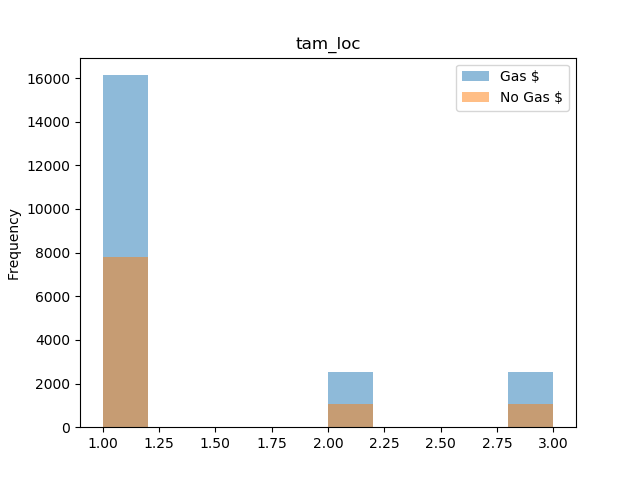

<IPython.core.display.Javascript object>


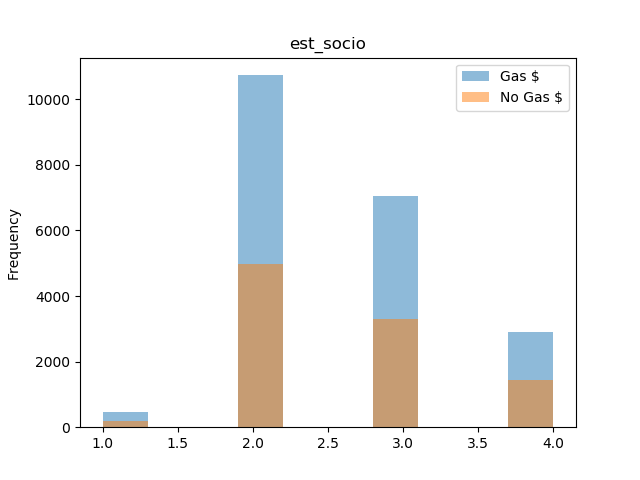

<IPython.core.display.Javascript object>


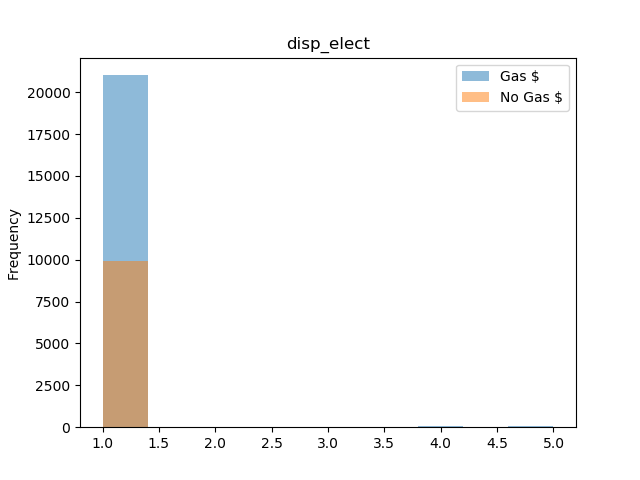

<IPython.core.display.Javascript object>


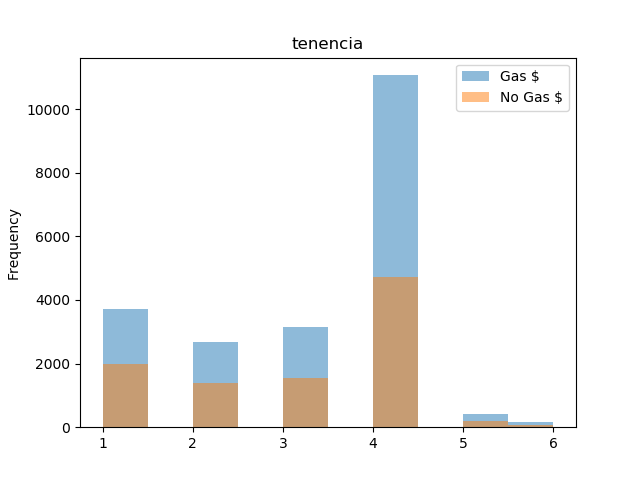

<IPython.core.display.Javascript object>


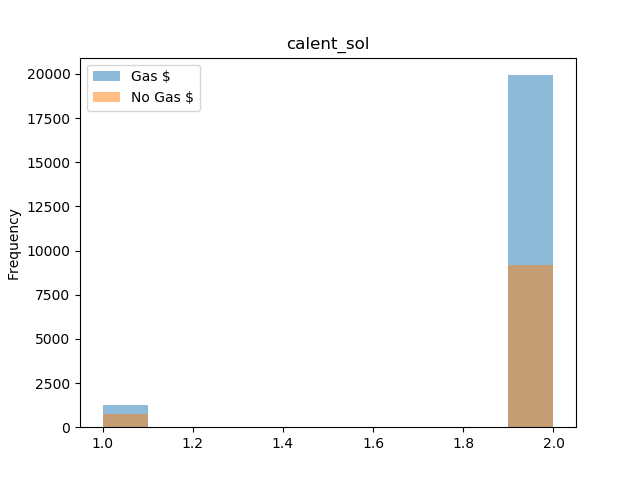

<IPython.core.display.Javascript object>


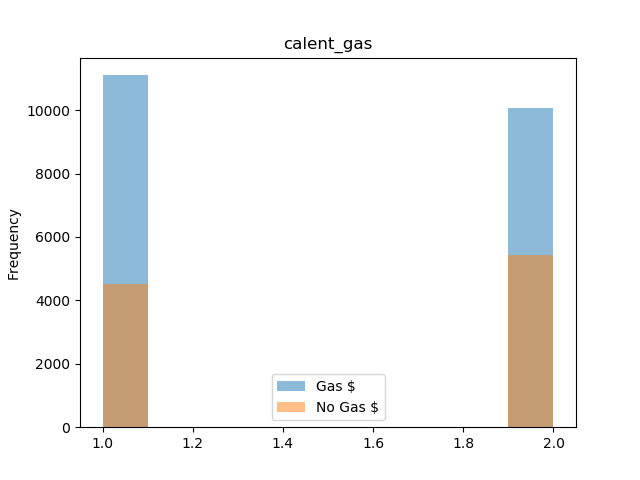

<IPython.core.display.Javascript object>


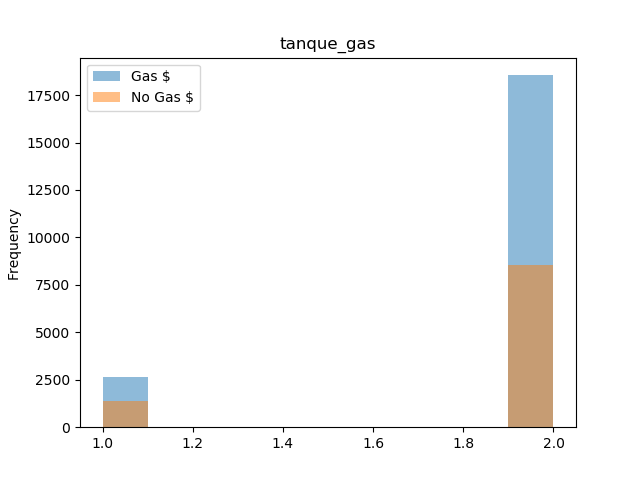

<IPython.core.display.Javascript object>


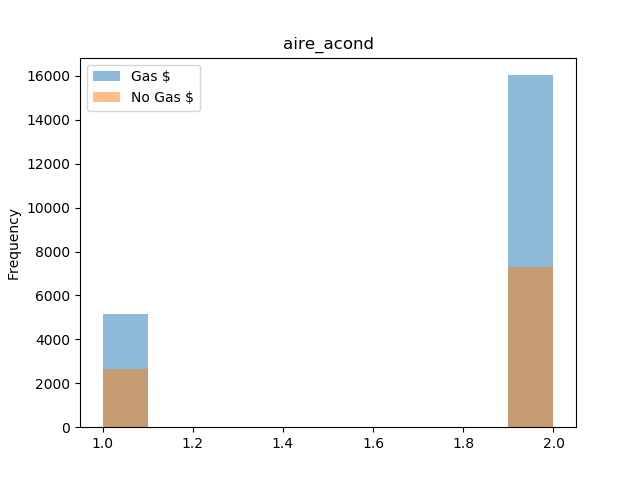

<IPython.core.display.Javascript object>


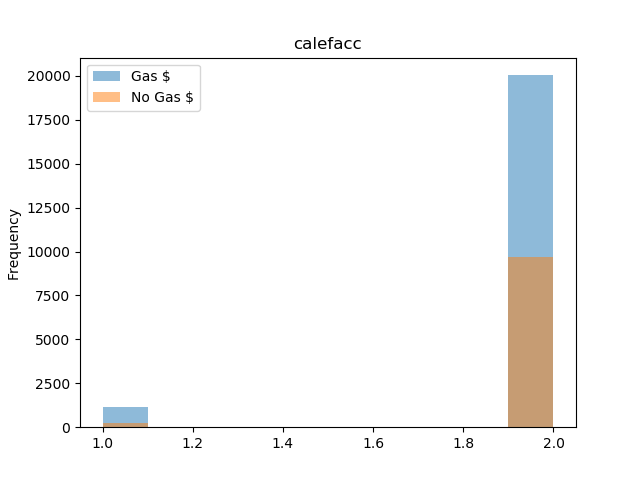

<IPython.core.display.Javascript object>


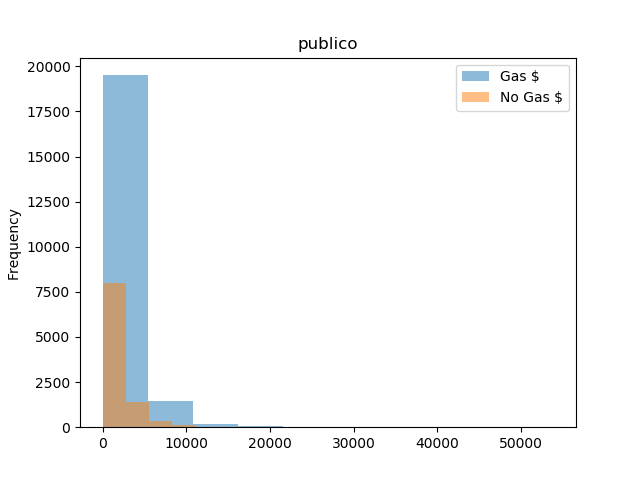

<IPython.core.display.Javascript object>


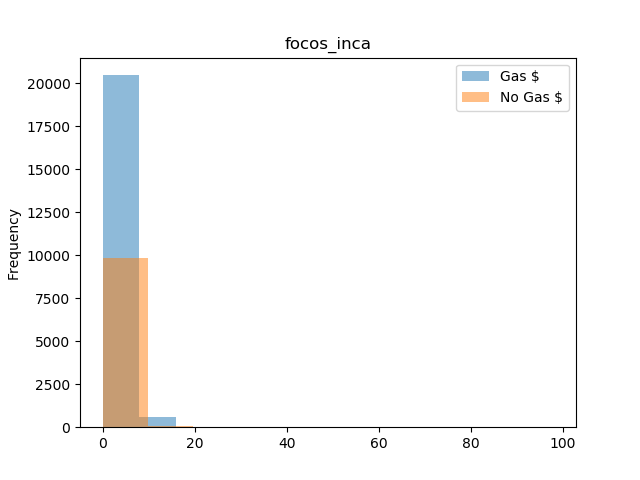

<IPython.core.display.Javascript object>


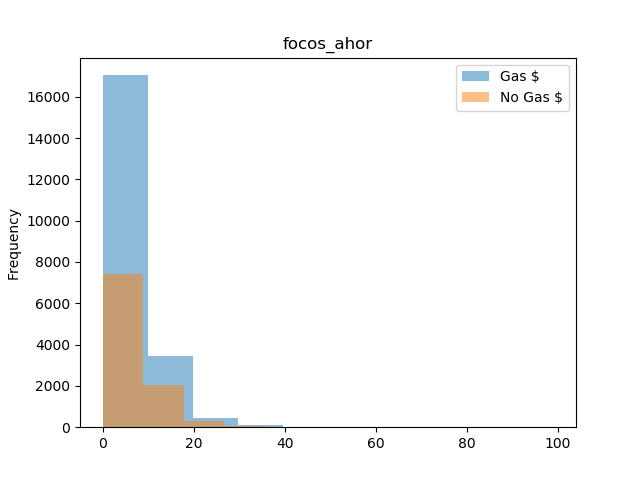

<IPython.core.display.Javascript object>


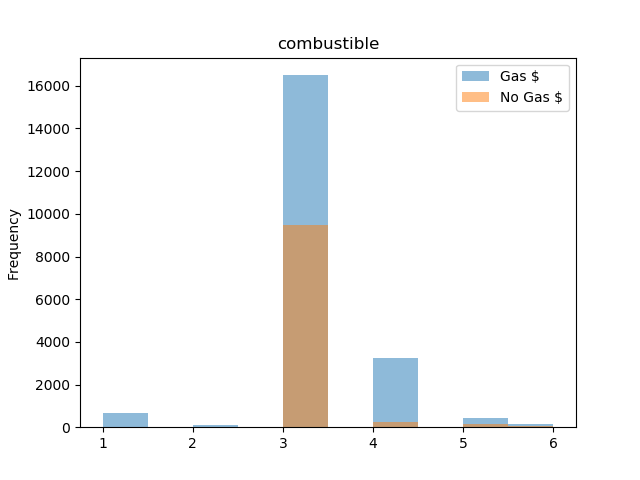

<IPython.core.display.Javascript object>


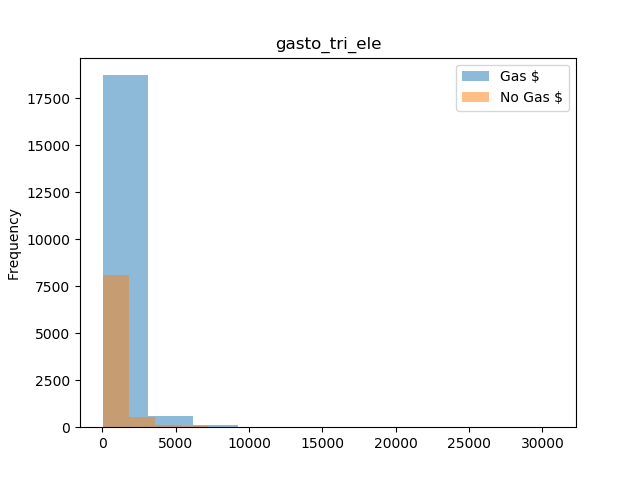

<IPython.core.display.Javascript object>


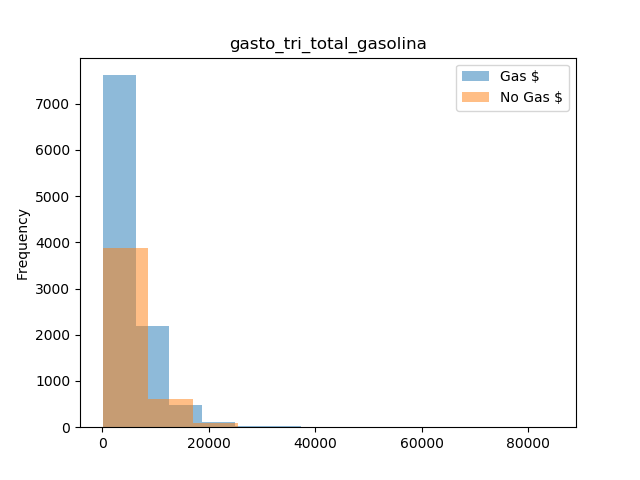

In [61]:
for i, col in enumerate(no_GasData[variables].columns):
    plt.figure(i)
    GasData[col].plot.hist(alpha=0.5, title=col, label='Gas $')
    no_GasData[col].plot.hist(alpha=0.5, label='No Gas $')
    plt.legend()